## <span style="color:green"> Notebook - Conversion of 2D Underworld Model II - Narrow Rift Inversion</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

In this notebook, we will convert a numerical model output from underworld to geophysical parameters, electrical conductivity and seismic velocity. First, let's import the functions we are going to use.

In [1]:
import os
from pathlib import Path

import pide
from pide.material import Material
from pide.model import Model
from pide.geodyn.read_uw_model import *
from pide.geodyn.interpolate_fields import interpolate_2d_fields
from pide.geodyn.plot_models import *
from pide.geodyn.material_process import *
from pide.geodyn.write_uw_model import write_2d_field_h5

#setting up source folder of the files
notebook_path = Path().resolve()
source_folder = os.path.join(notebook_path,'..','example_data','uwconversion', 'NRift')

/home/sinan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Reading the data files of thermomechanical model outputs in h5 formats. They can be read by the ***read_h5_file*** function.

In [2]:
#setting up filename folders for the h5 files.
temp_fnm = os.path.join(source_folder,'temperature-152.h5')
pstrain_fnm = os.path.join(source_folder,'projPlasticStrain-152.h5')
material_fnm = os.path.join(source_folder,'projMaterialField-152.h5')
melt_fnm = os.path.join(source_folder,'projMeltField-152.h5')
pressure_fnm = os.path.join(source_folder,'pressureField-152.h5')
mesh_fnm = os.path.join(source_folder,'mesh.h5')

py_start_fnm = os.path.join(source_folder,'NRiftExtInv.py')

temp_data = read_h5_file(temp_fnm)
pressure_data = read_h5_file(pressure_fnm)
mesh_data = read_h5_file(mesh_fnm)
material_data = read_h5_file(material_fnm)
pstrain_data = read_h5_file(pstrain_fnm)
melt_data = read_h5_file(melt_fnm)



We can scrape the material names and their relevant index numbers from the input python script with ***read_uw_material_names*** function. 2D mesh can be set up by ***setup_2d_mesh***. It outputs mesh (np.meshgrid), mesh_center (np.meshgrid), x_mesh and y_mesh (1D np.arrays of mesh), x_mesh_centers and y_mesh centers (1D np.arrays of mesh centers). With the given material_names, we can set up the material array in concordance with the mesh using ***setup_material*** function.

In [3]:
#reading startup py file to get material order and properties.
material_names = read_uw_material_names_from_py_input(py_start_fnm)

#reading 2d mesh params mesh itself, mesh_centers mesh, array in x direction, array in y direction, borders of the mesh[max_x, min_x, max_y, min_y]
mesh, mesh_center, x_mesh, y_mesh, x_mesh_centers, y_mesh_centers, borders_mesh = setup_2d_mesh(mesh_data)

#getting material_array
material_array, air_material_idx = setup_material(material_data, material_names)

#######################
Setting up the mesh parameters...
                    
                    
                    
Maximum X:  680.0   km
Minimum X:  0.0   km
Maximum Y:  190.0   km
Minimum Y:  -30.000000000000007   km
 
Materials included in the py startup file, matching up with the projMaterial.h5 material index identifiers.
id    materialname
1    air
2    sediment
3    Sediment1
4    Sediment2
5    Sediment3
6    Sediment4
7    Sediment5
8    Sediment6
9    continentalcrustL3
10    continentalcrustL4
11    continentalcrustL5
12    continentalcrustL6
13    continentalcrustL7
14    continentalcrustL8
15    continentalcrustL9
16    continentalcrustL10
17    uppermantle
18    asthenosphere


Read data files can be turned into np arrays with ***setup_uw_data_array_PROJ_2D***.

In [4]:
#getting strain array
pstrain_array = setup_uw_data_array_PROJ_2D(pstrain_data)
melt_array = setup_uw_data_array_PROJ_2D(melt_data)

temp_array = setup_uw_data_array_PROJ_2D(temp_data) #mesh
pressure_array = setup_uw_data_array_PROJ_2D(pressure_data) / 1e9 #converting to gigapascal

In underworld outputs, PROJ files are smaller in size and also contains data at the mesh centers. On the other hand, some fields are not projected and appear on nodes. To make all our calculations agree with each other. We interpolate all the data to mesh_center locations. This can be done by using ***interpolate_2d_fields*** function. For material_array, it is important to use method as 'nearest' since we do not want floating numbers at the mesh centers and only integers as material indexes.

In [5]:
#Converting larger arrays into mesh_center locations.
temp_array = interpolate_2d_fields(mesh,temp_array,mesh_center)
pressure_array = interpolate_2d_fields(mesh_center,pressure_array,mesh_center)
melt_array = interpolate_2d_fields(mesh,melt_array,mesh_center)
pstrain_array = interpolate_2d_fields(mesh,pstrain_array,mesh_center)
material_array = interpolate_2d_fields(mesh,material_array,mesh_center,method = 'nearest') #using nearest for the material for them to stay integers

These values now can be plotted with ***plot_2D_underworld_Field*** function. 

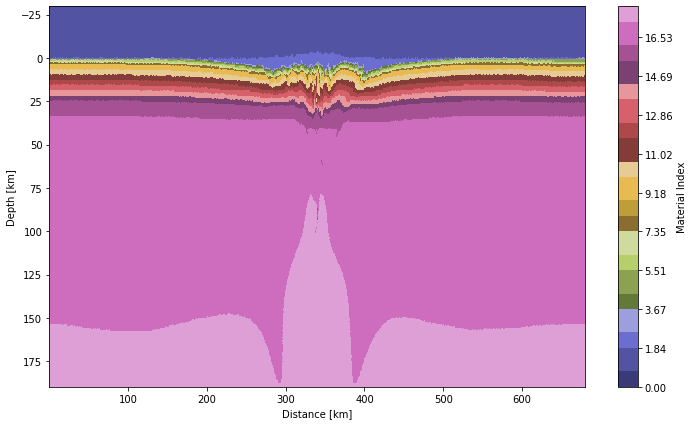

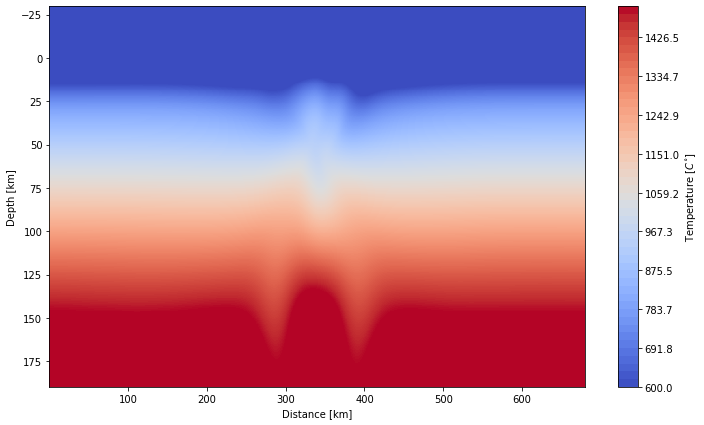

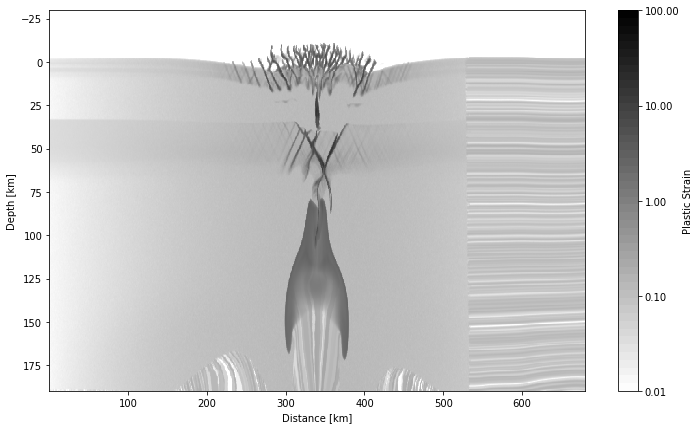

In [6]:
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = material_array,cblimit_up = len(material_names), cblimit_down = 0,
                         log_bool=False, cb_name = 'tab20b',label = 'material.png', cbar_label = 'Material Index',plot_save = False)
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = temp_array, cblimit_up = 1500, cblimit_down = 600,
                         log_bool=False, cb_name = 'coolwarm', label = 'temperature.png',cbar_label = r'Temperature [$C^{\circ}$]', plot_save = False)
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = pstrain_array,cblimit_up = 1e2, cblimit_down = 1e-2, log_bool=True,
                         cb_name = 'binary', cbar_label = 'Plastic Strain',plot_save = False)


To convert the thermomechanical model into geophysical observables, we first have to define material objects that will correspond to materials used in the thermomechanical model. To set this up we have to refer to the material indexes we scraped from the .py file earlier. In this current example we have 14 materials. In these we will define their composition, mineral interconnectivities, water thermodynamic parameters, and how they will behave when they are to be used with ***deform_cond*** functions, which we will get into it in the later cells. For now, we will going to define two materials for each material we see in the thermomechanical model. One that is a 'background' or 'boring' conductivity model. With this, we will have a conservative estimate of the electrical conductivity. On the other hand, we will also define the most conductive endmember composition and conditions for that material. For instance, in the following cell we will define Eclogites as *Eclogite_Object* and *Eclogite_Object_2*:

Eclogite_Object: An dry eclogitic composition where conductivity is controlled by the volumetric percentages of constituent minerals, i.e. Hashin-Shtrikman Model.
Eclogite_Object_2: A dry eclogitic composition where 5% sulphides added into the composition and they are perfectly interconnected.

In [7]:
import pide
from pide.material import Material
p_obj = pide.pide()

################
#Loose sediments
Sediment_0 = Material(name = 'Sediment_0', material_index = 2, calculation_type = 'value',
resistivity_medium = 50.0,vp_medium = 6,vs_medium = 3,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2,'strain_decay_factor':0.3,'strain_percolation_threshold':None})

Sediment_0_b = Material(name = 'Sediment_0', material_index = 2, calculation_type = 'value',
resistivity_medium = 1.0,vp_medium = 6,vs_medium = 3,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2,'strain_decay_factor':0.3,'strain_percolation_threshold':None})

In a similar manner, we can define the remaining materials as we like to as well:

In [8]:
################
#Sediment Layers
Sediment_1 = Material(name = 'Sediment_1', material_index = 3, calculation_type = 'value',
resistivity_medium = 100.0,vp_medium = 6,vs_medium = 3,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2,'strain_decay_factor':0.3,'strain_percolation_threshold':None})

Sediment_1_b = Material(name = 'Sediment_1', material_index = 3, calculation_type = 'value',
resistivity_medium = 10.0,vp_medium = 6,vs_medium = 3,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2,'strain_decay_factor':0.3,'strain_percolation_threshold':None})

#We want to define empty materials with similar compositional varieties but only change some of those attributes
Sediment_2 = Material()
Sediment_2_b = Material()
Sediment_3 = Material()
Sediment_3_b = Material()
Sediment_4 = Material()
Sediment_4_b = Material()
Sediment_5 = Material()
Sediment_5_b = Material()
Sediment_6 = Material()
Sediment_6_b = Material()

#Using copy attributes from Sediment_1 objects.
Sediment_1.copy_attributes([Sediment_2,Sediment_3,Sediment_4,Sediment_5,Sediment_6])
Sediment_1_b.copy_attributes([Sediment_2_b,Sediment_3_b,Sediment_4_b,Sediment_5_b,Sediment_6_b])

Sediment_2.material_index = 4
Sediment_3.material_index = 5
Sediment_4.material_index = 6
Sediment_5.material_index = 7
Sediment_6.material_index = 8

Sediment_2_b.material_index = 4
Sediment_3_b.material_index = 5
Sediment_4_b.material_index = 6
Sediment_5_b.material_index = 7
Sediment_6_b.material_index = 8

In [9]:
################
#Upper crust layers
Granitic_Upper_Crust = Material(name = 'Granitic_Upper_Crust', material_index = 9, calculation_type = 'mineral', composition = {'kfelds': 0.30, 'quartz': 0.35, 'plag': 0.25, 'amp': 0.1},
el_cond_selections = {'plag':1, 'garnet': 0, 'opx':0, 'amp':0, 'quartz': 7}, solid_phase_mixing_idx = 1,
                                param1 = {'plag':0.1},
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,
                    'strain_percolation_threshold':None})

Granitic_Upper_Crust_b = Material(name = 'Granitic_Upper_Crust', material_index = 9, calculation_type = 'mineral', composition = {'kfelds': 0.285, 'quartz': 0.3325, 'plag': 0.2375, 'amp': 0.095,'sulphide': 0.05},
el_cond_selections = {'plag':1, 'garnet': 0, 'opx':0, 'amp':0, 'quartz': 7}, solid_phase_mixing_idx = 2,
                                  param1 = {'plag':0.1},
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,
                    'strain_percolation_threshold':None})

Granitic_Upper_Crust_2 = Material()
Granitic_Upper_Crust_2_b = Material()
Granitic_Upper_Crust_3 = Material()
Granitic_Upper_Crust_3_b = Material()

Granitic_Upper_Crust.copy_attributes([Granitic_Upper_Crust_2, Granitic_Upper_Crust_3])
Granitic_Upper_Crust_b.copy_attributes([Granitic_Upper_Crust_2_b, Granitic_Upper_Crust_3_b])

Granitic_Upper_Crust_2.material_index = 10
Granitic_Upper_Crust_3.material_index = 11
Granitic_Upper_Crust_2_b.material_index = 10
Granitic_Upper_Crust_3_b.material_index = 11

In [10]:
#Felsic Granulite Layers
Felsic_Granulite_Lower_Crust = Material(name = 'Felsic_Granulite_Lower_Crust', material_index=12, calculation_type = 'mineral', composition = {'plag':0.45, 'garnet': 0.25,
'opx':0.05, 'amp':0.1, 'quartz': 0.15},
el_cond_selections = {'plag':1, 'garnet': 0, 'opx':0, 'amp':0, 'quartz': 7}, solid_phase_mixing_idx = 1,
                                        param1 = {'plag':0.1},
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,
                    'strain_percolation_threshold':None})

Felsic_Granulite_Lower_Crust_b = Material(name = 'Felsic_Granulite_Lower_Crust_b', material_index=12, calculation_type = 'mineral', composition = {'plag':0.4275, 'garnet': 0.2375,
'opx':0.0475, 'amp':0.095, 'quartz': 0.1425, 'sulphide': 0.05},
el_cond_selections = {'plag':1, 'garnet': 0, 'opx':0, 'amp':0, 'quartz': 7, 'sulphide': 0}, solid_phase_mixing_idx = 2,
                                          param1 = {'plag':0.1},
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,'strain_percolation_threshold':None})

Felsic_Granulite_Lower_Crust_2 = Material()
Felsic_Granulite_Lower_Crust_2_b = Material()
Felsic_Granulite_Lower_Crust_3 = Material()
Felsic_Granulite_Lower_Crust_3_b = Material()

Felsic_Granulite_Lower_Crust.copy_attributes([Felsic_Granulite_Lower_Crust_2, Felsic_Granulite_Lower_Crust_3])
Felsic_Granulite_Lower_Crust_b.copy_attributes([Felsic_Granulite_Lower_Crust_2_b, Felsic_Granulite_Lower_Crust_3_b])

Felsic_Granulite_Lower_Crust_2.material_index = 13
Felsic_Granulite_Lower_Crust_3.material_index = 14
Felsic_Granulite_Lower_Crust_2_b.material_index = 13
Felsic_Granulite_Lower_Crust_3_b.material_index = 14

In [11]:
#Mafic Granulite Layers
Mafic_Granulite_Lower_Crust = Material(name = 'Mafic_Granulite_Lower_Crust', material_index=15, calculation_type = 'mineral', composition = {'plag':0.31, 'garnet':0.19,
'cpx':0.25, 'opx':0.05,'amp':0.12, 'quartz':0.04,'kfelds':0.03,'other':0.01},param1 = {'plag':0.1},
el_cond_selections = {'plag':1, 'garnet': 0, 'opx':0, 'amp':0, 'quartz': 7, 'cpx':9, 'kfelds':2, 'other':0}, solid_phase_mixing_idx = 1,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,'strain_percolation_threshold':None})

Mafic_Granulite_Lower_Crust_b = Material(name = 'Mafic_Granulite_Lower_Crust_b', material_index=15, calculation_type = 'mineral', composition = {'plag':0.2945, 'garnet':0.1805,
'cpx':0.2375, 'opx':0.0475,'amp':0.114, 'quartz':0.038,'kfelds':0.0285,'other':0.0095, 'sulphide': 0.05},param1 = {'plag':0.1},
el_cond_selections = {'plag':1, 'garnet': 0, 'opx':0, 'amp':0, 'quartz': 7, 'cpx':9, 'kfelds':2, 'other':0, 'sulphide': 0}, solid_phase_mixing_idx = 2,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,'strain_percolation_threshold':None})

Mafic_Granulite_Lower_Crust_2 = Material()
Mafic_Granulite_Lower_Crust_2_b = Material()


Mafic_Granulite_Lower_Crust.copy_attributes(Mafic_Granulite_Lower_Crust_2)
Mafic_Granulite_Lower_Crust_b.copy_attributes(Mafic_Granulite_Lower_Crust_2_b)

Mafic_Granulite_Lower_Crust_2.material_index = 16
Mafic_Granulite_Lower_Crust_2_b.material_index = 16


In [12]:
#Mantle
Upper_Mantle = Material(name = 'Upper_Mantle', material_index = 17,
calculation_type = 'mineral', composition = {'ol':0.65,'opx':0.25,'garnet':0.05,'cpx':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0}, water_distr = True, water = {'bulk':100},
xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,'strain_percolation_threshold':None})

Upper_Mantle_b = Material(name = 'Upper_Mantle', material_index = 17, 
calculation_type = 'mineral', composition = {'ol':0.62,'opx':0.24,'garnet':0.045,'cpx':0.045,'sulphide':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5,'sulphide':1}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0,'sulphide':0}, water_distr = True, water = {'bulk':100},
xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,'strain_percolation_threshold':None})

#Asthenospheric mantle - A lherzolite with 100 ppm water object where conductive counterpart has 300 ppm water in it. 
Asthenosphere = Material(name = 'Asthenospheric_Mantle_Object', material_index = 18, 
calculation_type = 'mineral', composition = {'ol':0.65,'opx':0.25,'garnet':0.05,'cpx':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0}, water_distr = True, water = {'bulk':100},
xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,'strain_percolation_threshold':None})

Asthenosphere_b = Material(name = 'Asthenospheric_Mantle_Object', material_index = 18,
calculation_type = 'mineral', composition = {'ol':0.65,'opx':0.25,'garnet':0.05,'cpx':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0}, water_distr = True, water = {'bulk':300},
xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.7, 'conductivity_decay_factor_2':0.2, 'strain_decay_factor':0.3,'strain_percolation_threshold':None})

Now, we want to put them in a list in order to put them in a *Model* object. We also want to define a *material_skip_list*, which is the node skip rate for eatch material included in the lists. This is useful for something like asthenosphere where we do not have much heterogeneity and value can be calculated on a basis of calculating only some of the nodes.

In [15]:
#creating material_object_list:
material_object_list = [Sediment_0, Sediment_1,Sediment_2,Sediment_3, Sediment_4,Sediment_5,Sediment_6,Granitic_Upper_Crust,Granitic_Upper_Crust_2,Granitic_Upper_Crust_3,
Felsic_Granulite_Lower_Crust,Felsic_Granulite_Lower_Crust_2,Felsic_Granulite_Lower_Crust_3,Mafic_Granulite_Lower_Crust,Mafic_Granulite_Lower_Crust_2,Upper_Mantle,Asthenosphere]

material_object_list_2 = [Sediment_0_b, Sediment_1_b,Sediment_2_b,Sediment_3_b, Sediment_4_b,Sediment_5_b,Sediment_6_b,Granitic_Upper_Crust_b,Granitic_Upper_Crust_2_b,Granitic_Upper_Crust_3_b,
Felsic_Granulite_Lower_Crust_b,Felsic_Granulite_Lower_Crust_2_b,Felsic_Granulite_Lower_Crust_3_b,Mafic_Granulite_Lower_Crust_b,Mafic_Granulite_Lower_Crust_2_b,Upper_Mantle_b,Asthenosphere_b]

material_skip_list = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,10,50]

Now, we are creating the model object by assigning it the material lists, material array, temperature, pressure, melt, and plastic strain fields. After that, we can simply calculate the conductivities by saying, ***object.calculate_conductivity***. Number of cpu can be specified.

In [16]:
#creating model_object
mt_model_object = Model(material_list = material_object_list, material_array = material_array, T = temp_array, P = pressure_array, model_type = 'underworld_2d', melt = melt_array,
p_strain = pstrain_array, material_node_skip_rate_list = material_skip_list)
backgr_cond = mt_model_object.calculate_model(type = 'conductivity', num_cpu = 6)

Initiating calculation for the materials appended to the model.
##############################################################
The conductivity for the material  Sediment_0  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Granitic_Upper_Crust  is calculated.
The conductivity for the material  Granitic_Upper_Crust  is calculated.
The conductivity for the material  Granitic_Upper_Crust  is calculated.
The conductivity for the material  Felsic_Granulite_Lower_Crust  is calculated.
The conductivity for the material  Felsic_Granulite_Lower_Crust  is calculated.
The conductivity for the material  Felsic_Granulite_Lower_Crust

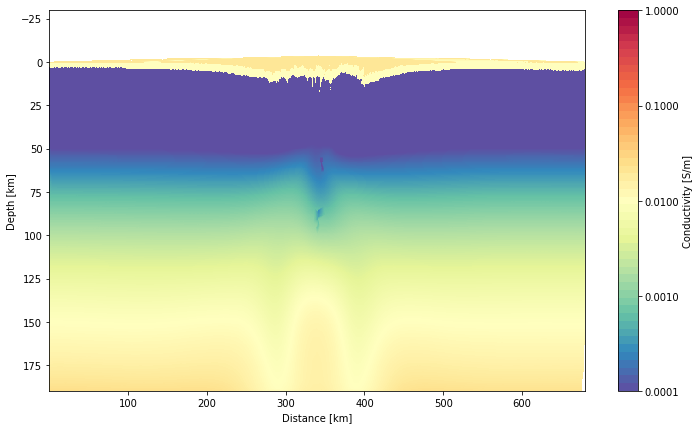

In [17]:
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = backgr_cond,cblimit_up = 1,
cblimit_down = 1e-4, log_bool=True, cb_name = 'Spectral_r',cbar_label = 'Conductivity [S/m]',plot_save = False)

In [18]:
#creating model_object
mt_model_object = Model(material_list = material_object_list_2, material_array = material_array, T = temp_array, P = pressure_array, model_type = 'underworld_2d', melt = melt_array,
p_strain = pstrain_array, material_node_skip_rate_list = material_skip_list)
max_cond = mt_model_object.calculate_model(type = 'conductivity', num_cpu = 6)

Initiating calculation for the materials appended to the model.
##############################################################
The conductivity for the material  Sediment_0  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Granitic_Upper_Crust  is calculated.
The conductivity for the material  Granitic_Upper_Crust  is calculated.
The conductivity for the material  Granitic_Upper_Crust  is calculated.
The conductivity for the material  Felsic_Granulite_Lower_Crust_b  is calculated.
The conductivity for the material  Felsic_Granulite_Lower_Crust_b  is calculated.
The conductivity for the material  Felsic_Granulite_Lower_C

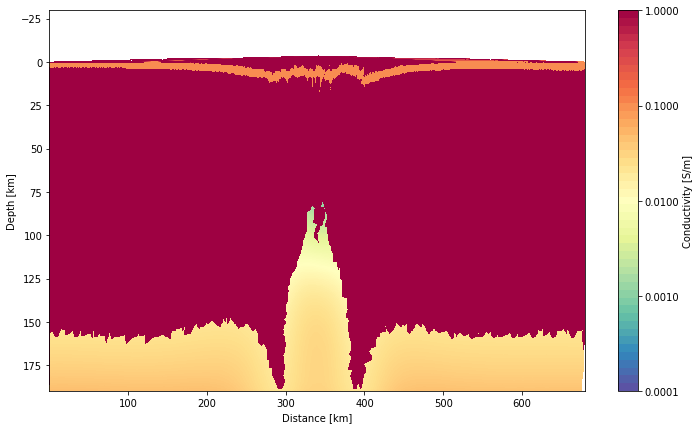

In [19]:
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = max_cond,cblimit_up = 1,
cblimit_down = 1e-4, log_bool=True, cb_name = 'Spectral_r',cbar_label = 'Conductivity [S/m]',plot_save = False)

In [20]:
deform_cond, rms = mt_model_object.calculate_deformation_related_conductivity(method = 'plastic_strain',
                                                        cond_min = backgr_cond,
                                                        cond_max = max_cond,
                                                        function_method = 'exponential',                                       
                                                        low_deformation_threshold = 1e-2, high_deformation_threshold = 10, num_cpu = 6)

The deformation related conductivity for the material  Sediment_0  is calculated.
The deformation related conductivity for the material  Sediment_1  is calculated.
The deformation related conductivity for the material  Sediment_1  is calculated.
The deformation related conductivity for the material  Sediment_1  is calculated.
The deformation related conductivity for the material  Sediment_1  is calculated.
The deformation related conductivity for the material  Sediment_1  is calculated.
The deformation related conductivity for the material  Sediment_1  is calculated.
The deformation related conductivity for the material  Granitic_Upper_Crust  is calculated.
The deformation related conductivity for the material  Granitic_Upper_Crust  is calculated.
The deformation related conductivity for the material  Granitic_Upper_Crust  is calculated.
The deformation related conductivity for the material  Felsic_Granulite_Lower_Crust_b  is calculated.
The deformation related conductivity for the mat

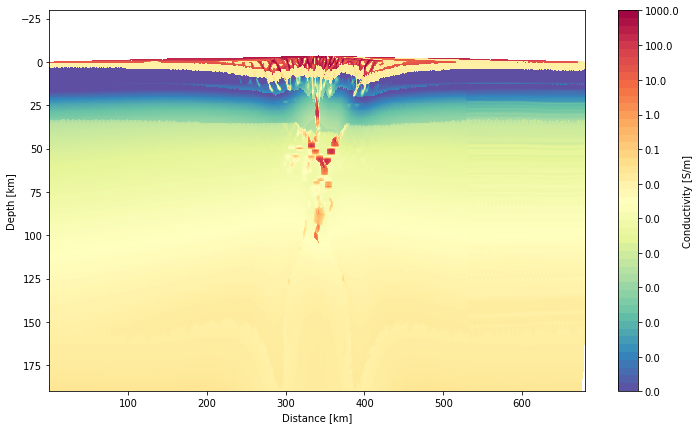

In [21]:
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = deform_cond,cblimit_up = 1e3,
cblimit_down = 1e-8, log_bool=True, cb_name = 'Spectral_r',cbar_label = 'Conductivity [S/m]',plot_save = False)

Using the first material list (conservative estimate), we can calculate the seismic velocities of the model with the following code block:

Initiating calculation for the materials appended to the model.
##############################################################
The conductivity for the material  Sediment_0  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Sediment_1  is calculated.
The conductivity for the material  Granitic_Upper_Crust  is calculated.
The conductivity for the material  Granitic_Upper_Crust  is calculated.
The conductivity for the material  Granitic_Upper_Crust  is calculated.
The conductivity for the material  Felsic_Granulite_Lower_Crust  is calculated.
The conductivity for the material  Felsic_Granulite_Lower_Crust  is calculated.
The conductivity for the material  Felsic_Granulite_Lower_Crust

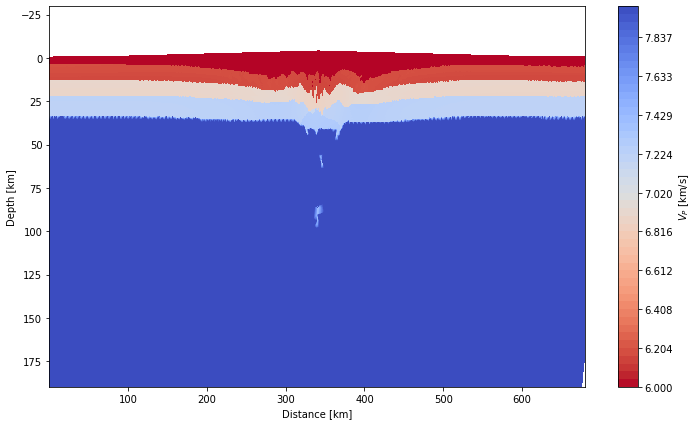

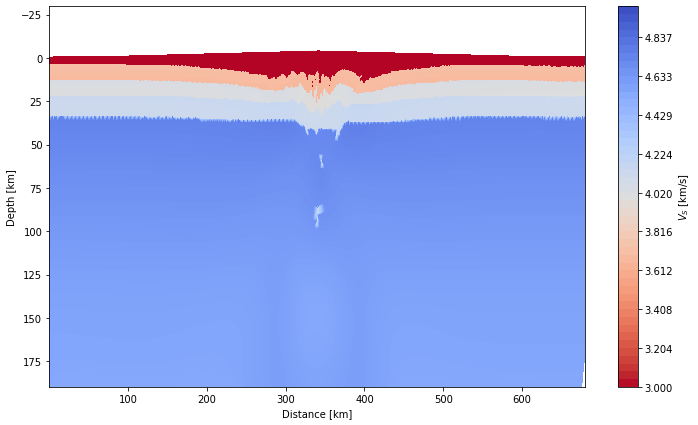

In [22]:
seismic_model_object = Model(material_list = material_object_list, material_array = material_array, T = temp_array,
                             P = pressure_array,
                        model_type = 'underworld_2d', melt = melt_array,
p_strain = pstrain_array, material_node_skip_rate_list = material_skip_list)

v_p, v_s = seismic_model_object.calculate_model(type = 'seismic', num_cpu = 5)

plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = v_p,cblimit_up = 8,
cblimit_down = 6, log_bool=False, cb_name = 'coolwarm_r',cbar_label = r'$V_P$ [km/s]',plot_save = False)

plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = v_s, cblimit_up = 5,
cblimit_down = 3, log_bool=False, cb_name = 'coolwarm_r',cbar_label = r'$V_S$ [km/s]',plot_save = False)

If the user wants to print out the results, one can use h5 file write functions included in `pide` as follows.

In [24]:
from pide.geodyn.write_uw_model import write_2d_field_h5
write_2d_field_h5(Field = deform_cond, filename_out='DeformCond.h5')

The file has written as:DeformCond.h5
